<h1><center> MODEL </center></h1>

 <center>
    <h1><center>Microsoft malware classification</center></h1>
    <i>Klasifikacija zlonamjernog softvera</i> 
    <br><br>
    PRIRODOSLOVNO MATEMATIČKI FAKULTET - MATEMATIČKI ODSJEK <br>
    <b>Lipanj 2020.</b> 
    <br><br>
    <i>Stanišić Matea, Škrabo Petra, Terzanović Mateja, Tolja Margarita</i>  
</center>

***

[comment]: <> (Paketi koje je potrebno instalirati prije pokretanja bilježnice: <br>)
[comment]: <> (<code>conda install -c anaconda py-xgboost</code> <br>)
[comment]: <> (<code>conda install -c conda-forge imbalanced-learn</code>)

In [1]:
# packages
import numpy as np
from numpy import mean
from numpy import std
from numpy import loadtxt
import pickle
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.cm as cm

from IPython.core.pylabtools import figsize
from collections import Counter
import random

import xgboost as xgb
from xgboost import XGBClassifier

from sklearn.model_selection import train_test_split as tts
from sklearn.metrics import precision_score, log_loss, accuracy_score, confusion_matrix
from sklearn.model_selection import learning_curve, cross_val_score, RepeatedStratifiedKFold, StratifiedKFold
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier, BaggingClassifier
from sklearn.utils import class_weight

from imblearn.over_sampling import RandomOverSampler, SMOTE, ADASYN
from imblearn.under_sampling import RandomUnderSampler

from functions.model_helper import *
from functions.fs_helper import *
from functions.draw_heatmap import *
from functions.build_model_helper import *

from yellowbrick.classifier import ClassBalance, ROCAUC
from yellowbrick.classifier import ClassificationReport, ClassPredictionError

import warnings
warnings.filterwarnings("ignore", category=RuntimeWarning)
warnings.filterwarnings('ignore', category=FutureWarning)


C:\Users\Matea\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:144: FutureWarning: The sklearn.metrics.classification module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.metrics. Anything that cannot be imported from sklearn.metrics is now part of the private API.
  warnings.warn(message, FutureWarning)


In [2]:
# remember default python style
# IPython_default = plt.rcParams.copy()

# dictionary for saving malware names
malware_dict = { 1 : 'Ramnit', 2 : 'Lollipop', 3 : 'Kelihos_ver3', 4 : 'Vundo', 5 : 'Simba', 
                 6 : 'Tracur', 7 : 'Kelihos_ver1', 8 : 'Obfuscator.ACY', 9 : 'Gatak'}

# define seed
seed = 42

# load train data malware classes
malware_classes_train = pd.read_csv("https://raw.githubusercontent.com/mateastanisic/lfs/master/malware_classes_train.csv")

<br><br>


#### učitavanje podataka

In [3]:
# loading all features in train set
features_train = pd.read_csv("https://raw.githubusercontent.com/mateastanisic/lfs/master/merged_all_features.csv")

# loading all features in train set
features_test1 = pd.read_csv("https://raw.githubusercontent.com/mateastanisic/lfs/master/test_features_first_10000.csv")
features_test2 = pd.read_csv("https://raw.githubusercontent.com/mateastanisic/lfs/master/test_features_last_873.csv")
features_test = features_test1.append(features_test2)

# malware ids
md5hash_train = pd.read_csv("https://raw.githubusercontent.com/mateastanisic/lfs/master/md5hash_train.csv")
md5hash_test = pd.read_csv("https://raw.githubusercontent.com/mateastanisic/lfs/master/md5hash_test.csv")

# load train data malware classes
malware_classes_train = pd.read_csv("https://raw.githubusercontent.com/mateastanisic/lfs/master/malware_classes_train.csv")

# features with filled NaN with zero
features_train_with_filled_NaN_without_id = pd.read_csv("https://raw.githubusercontent.com/mateastanisic/lfs/master/features_train_with_filled_NaN_without_id.csv")
features_test_with_filled_NaN_without_id = pd.read_csv("https://raw.githubusercontent.com/mateastanisic/lfs/master/features_test_with_filled_NaN_without_id.csv")

In [4]:
# select feature set based on different feature selection techniques
[feature_importances, selected_features_train, selected_features_test] = choose_features()

# print number of features in selected dataset
print('Broj odabranih značajki: ', len(feature_importances["feature_name"]))

1. accuracy 
2. roc_auc_ovo 
3. f1_micro 
Koje značajke želim s obzirom na scoring parametar u RFECV-u? 1

1. univarijantna metoda + rfecv 
2. samo rfecv 
3. univarijantna metoda + izbacivanje koreliranih značajki + rfecv 
4. izbacivanje koreliranih značajki + rfecv 
Koje značajke želim s obzirom na korištene feature selection tehnike? 4

Broj odabranih značajki:  78


In [5]:
feature_importances.head()

,feature_name,feature_importance
0,byte_offset,0.026690
1,string_len_counts_98,0.025986
2,byte_1G_a4,0.023056
3,byte_1G_a7,0.022924
4,byte_1G_a2,0.022627


<br><br>


#### ako želimo još smanjiti broj značajku s obzirom na njhovu značajnost

In [6]:
# define number of features to use

# all
number_of_features_to_use = len(feature_importances["feature_name"].values)

# or some (be shure that number is smaller than actual number of features)
# number_of_features_to_use = 50

<br><br>

#### definiranje podataka na kojima radimo model

In [7]:
# define data
data = selected_features_train[ list(feature_importances["feature_name"].values[:number_of_features_to_use]) ]
data_test = selected_features_test[ list(feature_importances["feature_name"].values[:number_of_features_to_use]) ]
labels = malware_classes_train.values.ravel()

In [8]:
data

,byte_offset,string_len_counts_98,byte_1G_a4,byte_1G_a7,byte_1G_a2,byte_1G_9a,byte_1G_b1,byte_1G_a9,byte_1G_ad,ent_q_diffs_max,...,ent_q_diff_diffs_max,ent_p_diffs_8,ent_p_diffs_3,asm_regs_ax,byte_1G_12,byte_1G_80,string_len_counts_16,asm_opcodes_xchg,asm_symb_Bracket_Close,ent_q_diffs_20
0,268439552,0,498,361,339,331,331,361,429,3.996103,...,0.073497,0.039203,0.399024,0,389,717,9,0,125,0.000000
1,1307774976,0,434,333,337,314,375,426,446,3.989588,...,0.051205,0.016872,0.192788,157,492,1274,7,1,11375,0.000000
2,268439552,0,213,409,242,206,240,208,207,3.993332,...,0.055035,0.216801,0.217904,2,308,721,2,0,2287,0.000000
3,2112880640,0,1181,997,676,670,800,674,667,3.981152,...,0.086315,0.019806,0.687564,210,1821,3538,51,3,41573,0.000000
4,268439552,0,306,281,254,255,275,268,303,3.998084,...,0.087461,0.408917,1.560694,0,287,1051,4,38,2663,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10862,4198400,0,3756,3142,4129,3150,3257,3114,3190,3.799025,...,0.074591,0.003480,0.005512,0,3202,4002,25,0,4605,0.000000
10863,4198400,0,295,269,283,303,269,364,274,3.893492,...,0.050043,0.002427,0.105445,0,357,466,7,0,729,0.000000
10864,4198400,1,1999,1886,1878,1948,1955,1886,2440,4.068274,...,0.101275,0.112604,0.001249,185,2011,2387,14,1,11578,0.000807
10865,4198400,0,389,293,331,300,289,297,302,3.690072,...,0.056194,0.001565,0.002280,0,326,437,10,0,1221,0.000000


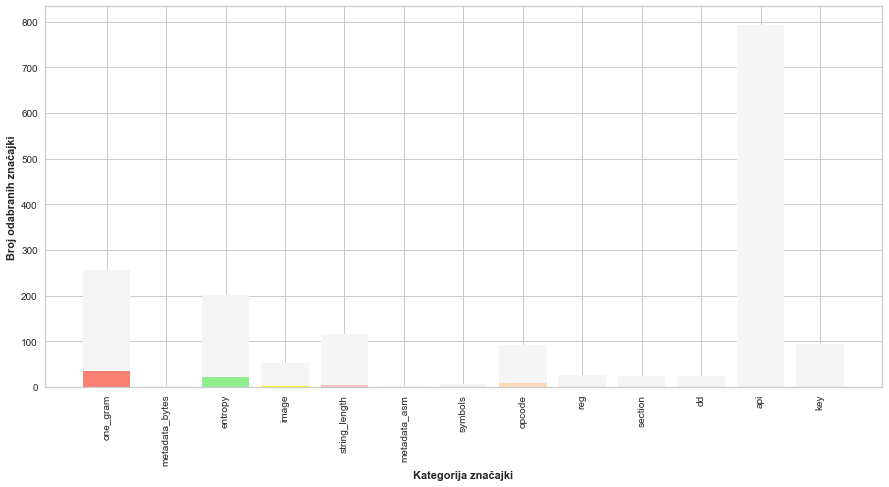

In [9]:
# distribution of features over groups of features
features_type_quantity(feature_importances["feature_name"].tolist(), features_train)

In [10]:
# split data
X_train, X_test, y_train, y_test = tts( data, labels, test_size=0.2, random_state=seed)

<br><br>



# XGBoost



<span style="color:orange"><i>Objasniti ukratko zašto smo odabrali ovaj klasifikator. ~> copy-paste sa nekih od starih radova </i></span>


<br><br><br>


### Nebalansirani podaci

<span style="color:orange"><i>Dakle rješavamo problem što nam je Simbe premalo.. </i> </span>

Broj malwarea po klasama:
dict_values([1541, 2477, 2942, 475, 42, 751, 398, 1228, 1013])
Postotci malware-aa po klasama:
[14.180546608999725, 22.793779331922334, 27.072789178246065, 4.371031563448974, 0.38649121192601454, 6.91083095610564, 3.662464341584614, 11.300266862979663, 9.321799944786969]


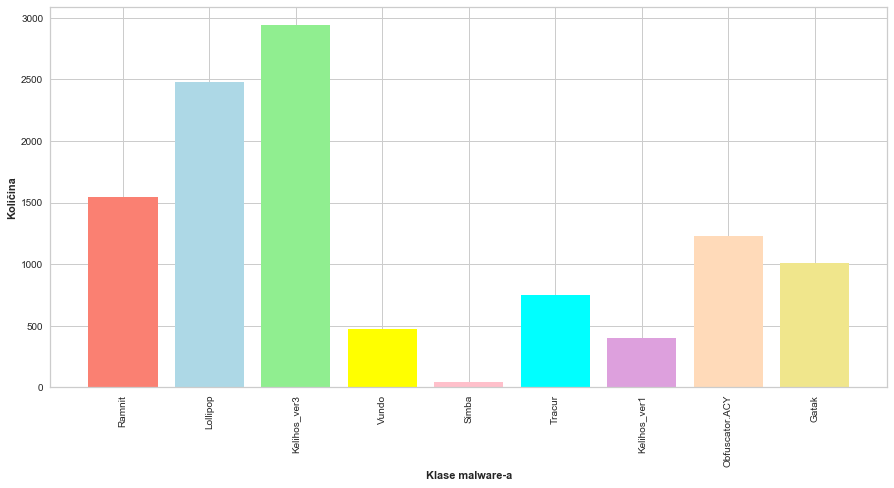

In [11]:
draw_malware_distribution_over_classes(malware_classes_train.values.ravel())

<br>

#### SMOTE

In [12]:
# split data
X_train, X_test, y_train, y_test = tts( data, labels, test_size=0.2, random_state=seed)

In [13]:
# define some values needed for building model
name    = input('Unesi jedinstveno ime za model: ')
cvs     = input("Unesi broj unakrsnih validacija: ")
cv      = int(cvs)
scoring = choose_scoring()

Unesi jedinstveno ime za model: klughjk
Unesi broj unakrsnih validacija: 2
1. accuracy
2. neg_log_loss
3. f1_micro
4. roc_auc_ovo
Unesi vrstu točnosti: 1


<br>

In [ ]:
# first explore SMOTE space with grid search
param_grid = {
    'sampling_strategy': ['minority', 'not minority', 'not majority', 'all'],
    'k_neighbors': [5, 10, 20]
}

[gss, gss_df] = GridSearchCV_for_SMOTE(name=name, param_grid=param_grid, data=X_train, labels=y_train, cv=cv, random_state=seed)

In [14]:
#Save model
#filename = 'GridSearchCV_testtesttest.sav'
#pickle.dump(gss, open(filename, 'wb'))

#Load model
#filename = 'GridSearchCV_testtesttest.sav'
#gss = pickle.load(open(filename, 'rb'))


In [31]:
if sum(gss.cv_results_['rank_test_score']) == len(gss.cv_results_['rank_test_score']):
    print("Svi su parametri iste značajnosti.")
    sampling_strategy = 'minority'
    k_neighbors = 10

Svi su parametri iste značajnosti.


<br><br>



#### RANDOM SEARCH XGBOOST PARAMETERS

In [ ]:
# define the parameter values that should be searched
n_estimators_range = [int(x) for x in np.linspace(start=70, stop=600, num=10)]

# learning range
learning_range = list(range(1, 31))
learning_range = [x / 10 for x in learning_range]

# regularization parameters
gamma = [ 0, 0.001, 0.005, 0.01, 0.1, 0.5] #default 0
reg_alpha = [0, 0.001, 0.005, 0.01, 0.05, 0.1] #default 0
reg_lambda = [0, 0.01, 0.1, 0.5, 0.75, 1] #default 1

#max depth of tree
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)

# minimum number of samples required to split a node
min_samples_split = [2, 5, 10]

# minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]

# method of selecting samples for training each tree
bootstrap = [True, False]

# dictionary of parameters
random_grid = {
               'n_estimators': n_estimators_range,
               'learning_rate': learning_range,
               'max_features': ['auto','log2'],
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap,
               'gamma' : gamma,
               'reg_alpha': reg_alpha,
               'reg_lambda': reg_lambda
              }

In [ ]:
# random search of xgb parameters
[rand_XGB, rand_XGB_results_df] = RandomizedSearchCV_with_SMOTE(name                  = name, 
                                                                data                  = X_train, 
                                                                labels                = y_train, 
                                                                random_grid           = random_grid, 
                                                                sampling_strategy     = sampling_strategy, 
                                                                k_neighbors           = k_neighbors,
                                                                cv                    = cv, 
                                                                scoring               = scoring, 
                                                                n_iter                = 20, 
                                                                random_state          = seed
                                                                )

In [15]:
#Load model
#filename = 'RandomizedSearchCV_testtest2.sav'
#rand_XGB = pickle.load(open(filename, 'rb'))

In [ ]:
rand_XGB_results_df

In [ ]:
from functions.model_helper import *

# examine the best n models
n = 3
best_n_models_params = report(rand_XGB_results_df, n_top=3)
best_para = report(rand_XGB_results_df, n_top=1)

<br><br>




#### GRID SEARCH XGBOOST PARAMETERS

In [ ]:
# grid search again, but here on xgboost paarmeters

In [ ]:
param_grid = {    'reg_lambda': [],
                  'reg_alpha': [],
                  'n_estimators': [],
                  'min_samples_split': [],
                  'min_samples_leaf': [],
                  'max_features': [],
                  'max_depth': [],
                  'learning_rate': [],
                  'gamma': [],
                  'bootstrap': []
              }

# adding parameters to be examined with GridSearch in params_grid
for key in param_grid.keys():
    for i in range(len(best_para)):
        if best_para[i][key] not in param_grid[key]:
            param_grid[key].append(best_para[i][key])
            
param_grid

In [ ]:
[gs_xgb, gs_xgb_df] = GridSearchCV_with_SMOTE(name=name,
                                              param_grid=param_grid, 
                                              sampling_strategy=sampling_strategy, 
                                              k_neighbors=k_neighbors, 
                                              data=X_train, 
                                              labels=y_train, 
                                              cv=cv, 
                                              random_state=seed)

In [16]:
#Load model
#filename = 'GridSearchCV_testtest2.sav'
#gs_xgb = pickle.load(open(filename, 'rb'))

In [ ]:
gs_xgb_df

In [ ]:
from functions.model_helper import *

# examine the best n models
n = 3
best_n_models_params = report(gs_xgb.cv_results_, n_top=3)

# best parameters
best_param_final = report(gs_xgb.cv_results_, n_top=1)

<br><br>

#### MODEL

In [17]:
[best_model, best_model_results_df] = XGBClassifier_with_SMOTE(name=name, 
                                                               grid_or_random_search=gs_xgb,
                                                               sampling_strategy=sampling_strategy,
                                                               k_neighbors=k_neighbors,
                                                               X_train=X_train, 
                                                               y_train=y_train, 
                                                               X_test=X_test, 
                                                               y_test=y_test, 
                                                               early_stopping_rounds=20, 
                                                               eval_metric=["merror", "mlogloss"], 
                                                               random_state=seed)

[(1, 1227), (2, 1991), (3, 2334), (4, 383), (5, 2334), (6, 601), (7, 320), (8, 988), (9, 814)]
[0]	validation_0-merror:0.010371	validation_0-mlogloss:0.554218	validation_1-merror:0.036339	validation_1-mlogloss:0.59744
Multiple eval metrics have been passed: 'validation_1-mlogloss' will be used for early stopping.

Will train until validation_1-mlogloss hasn't improved in 20 rounds.
[1]	validation_0-merror:0.002729	validation_0-mlogloss:0.319818	validation_1-merror:0.017939	validation_1-mlogloss:0.367012
[2]	validation_0-merror:0.00191	validation_0-mlogloss:0.191784	validation_1-merror:0.014259	validation_1-mlogloss:0.238217
[3]	validation_0-merror:0.001365	validation_0-mlogloss:0.117442	validation_1-merror:0.013339	validation_1-mlogloss:0.160955
[4]	validation_0-merror:0.00091	validation_0-mlogloss:0.072849	validation_1-merror:0.01196	validation_1-mlogloss:0.113317
[5]	validation_0-merror:0.000455	validation_0-mlogloss:0.045852	validation_1-merror:0.0115	validation_1-mlogloss:0.083195


[68]	validation_0-merror:0	validation_0-mlogloss:0.000459	validation_1-merror:0.00644	validation_1-mlogloss:0.017634
[69]	validation_0-merror:0	validation_0-mlogloss:0.000457	validation_1-merror:0.00644	validation_1-mlogloss:0.017645
[70]	validation_0-merror:0	validation_0-mlogloss:0.000455	validation_1-merror:0.00644	validation_1-mlogloss:0.017628
[71]	validation_0-merror:0	validation_0-mlogloss:0.000453	validation_1-merror:0.00644	validation_1-mlogloss:0.017574
[72]	validation_0-merror:0	validation_0-mlogloss:0.000452	validation_1-merror:0.00644	validation_1-mlogloss:0.017593
[73]	validation_0-merror:0	validation_0-mlogloss:0.00045	validation_1-merror:0.00644	validation_1-mlogloss:0.017564
[74]	validation_0-merror:0	validation_0-mlogloss:0.000448	validation_1-merror:0.00644	validation_1-mlogloss:0.017676
[75]	validation_0-merror:0	validation_0-mlogloss:0.000446	validation_1-merror:0.00644	validation_1-mlogloss:0.017594
[76]	validation_0-merror:0	validation_0-mlogloss:0.000445	validat

[138]	validation_0-merror:0	validation_0-mlogloss:0.000403	validation_1-merror:0.00598	validation_1-mlogloss:0.017344
[139]	validation_0-merror:0	validation_0-mlogloss:0.000403	validation_1-merror:0.00598	validation_1-mlogloss:0.017344
[140]	validation_0-merror:0	validation_0-mlogloss:0.000403	validation_1-merror:0.00598	validation_1-mlogloss:0.017344
[141]	validation_0-merror:0	validation_0-mlogloss:0.000403	validation_1-merror:0.00598	validation_1-mlogloss:0.017344
Stopping. Best iteration:
[121]	validation_0-merror:0	validation_0-mlogloss:0.000403	validation_1-merror:0.00598	validation_1-mlogloss:0.017304

XGBClassifier je spremljen u: XGBClassifier_klughjk.sav


NameError: name 'model_results' is not defined

In [18]:
#Load model
filename = 'XGBClassifier_klughjk.sav'
best_model = pickle.load(open(filename, 'rb'))

# show results
param_tuning_xgb_results_df = model_results(best_model, X_test, y_test)
param_tuning_xgb_results_df

Uspješnost modela:


,metrika,uspješnost
0,logloss,0.017304
1,accuracy_test,0.994020
2,F1_test,0.994022
3,precision_test,0.994086
4,auc_test_ovr,0.999973
5,auc_test_ovo,0.999970
6,r2_test,0.972197


In [19]:
best_model_results_df

NameError: name 'best_model_results_df' is not defined

<br> 



In [20]:
model = best_model

In [21]:
best_results = model_results(model, X_test, y_test)
best_results

Uspješnost modela:


,metrika,uspješnost
0,logloss,0.017304
1,accuracy_test,0.994020
2,F1_test,0.994022
3,precision_test,0.994086
4,auc_test_ovr,0.999973
5,auc_test_ovo,0.999970
6,r2_test,0.972197


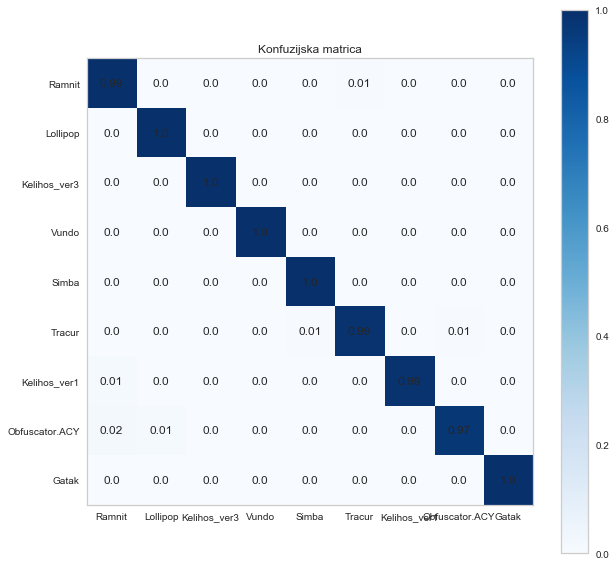

In [22]:
#plt.style.use(plt.style.available[10])
make_and_plot_confusion_matrix(y_test, model.predict(X_test))

C:\Users\Matea\anaconda3\lib\site-packages\yellowbrick\classifier\base.py:250: YellowbrickWarning: both classes and encoder specified, using encoder
  "both classes and encoder specified, using encoder", YellowbrickWarning
C:\Users\Matea\anaconda3\lib\site-packages\yellowbrick\classifier\base.py:232: YellowbrickWarning: could not determine class_counts_ from previously fitted classifier
  YellowbrickWarning,


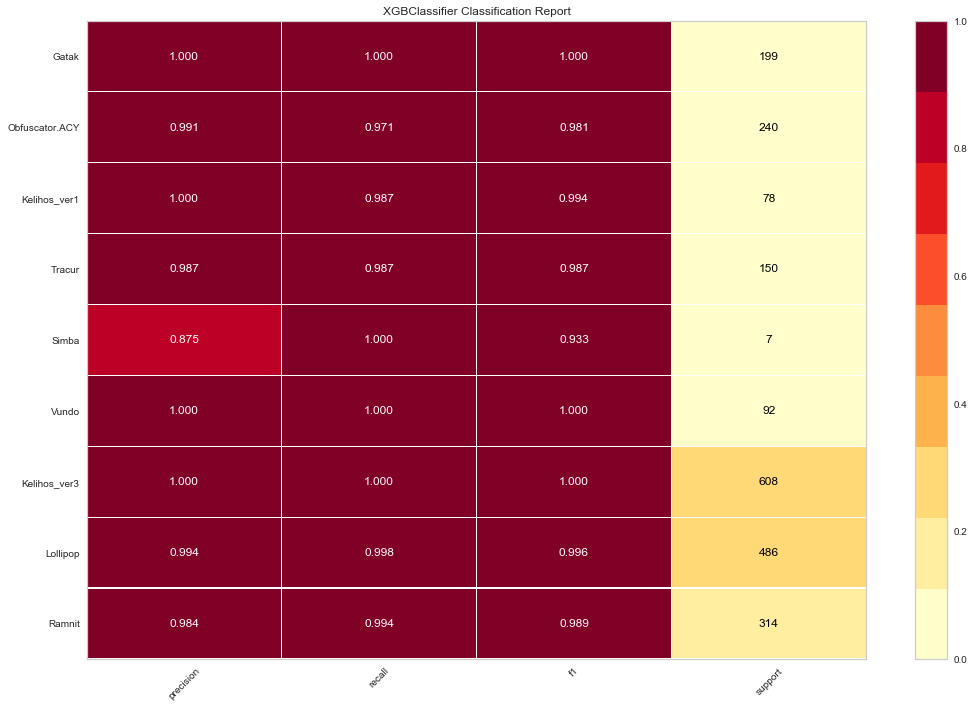

In [23]:
report = ClassificationReport(model, size=(1080, 720), support=True, force_model=True, classes=list(malware_dict.values()), encoder=malware_dict)

report.score(X_test, y_test)
c = report.poof()

Broj malwarea po klasama:
dict_values([1543, 2480, 2946, 480, 49, 756, 400, 1208, 1011])
Postotci malware-aa po klasama:
[14.191115607468042, 22.808792421594777, 27.094638094362182, 4.414604984824795, 0.45065759220086454, 6.953002851099052, 3.678837487353996, 11.110089211809068, 9.298261749287224]


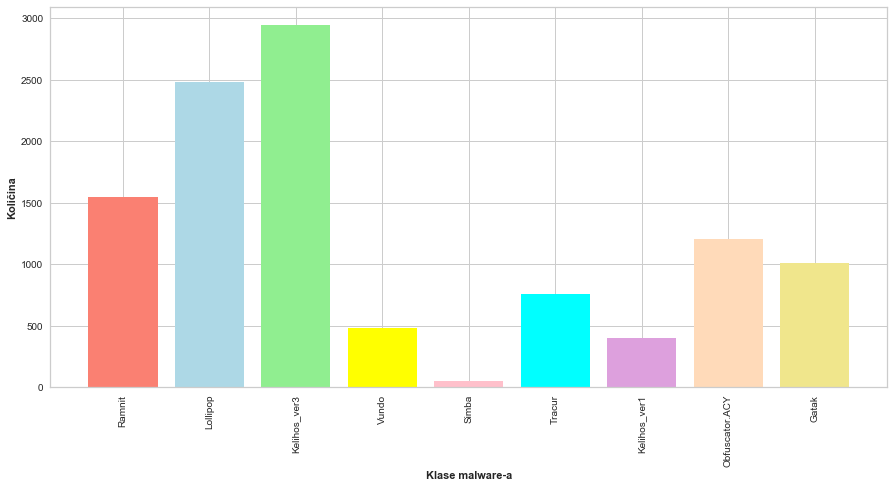

In [24]:
predicted_classes_on_kaggle_testset = np.asarray(model.predict(selected_features_test[ list(feature_importances["feature_name"].values[:number_of_features_to_use]) ]))
draw_malware_distribution_over_classes(predicted_classes_on_kaggle_testset)

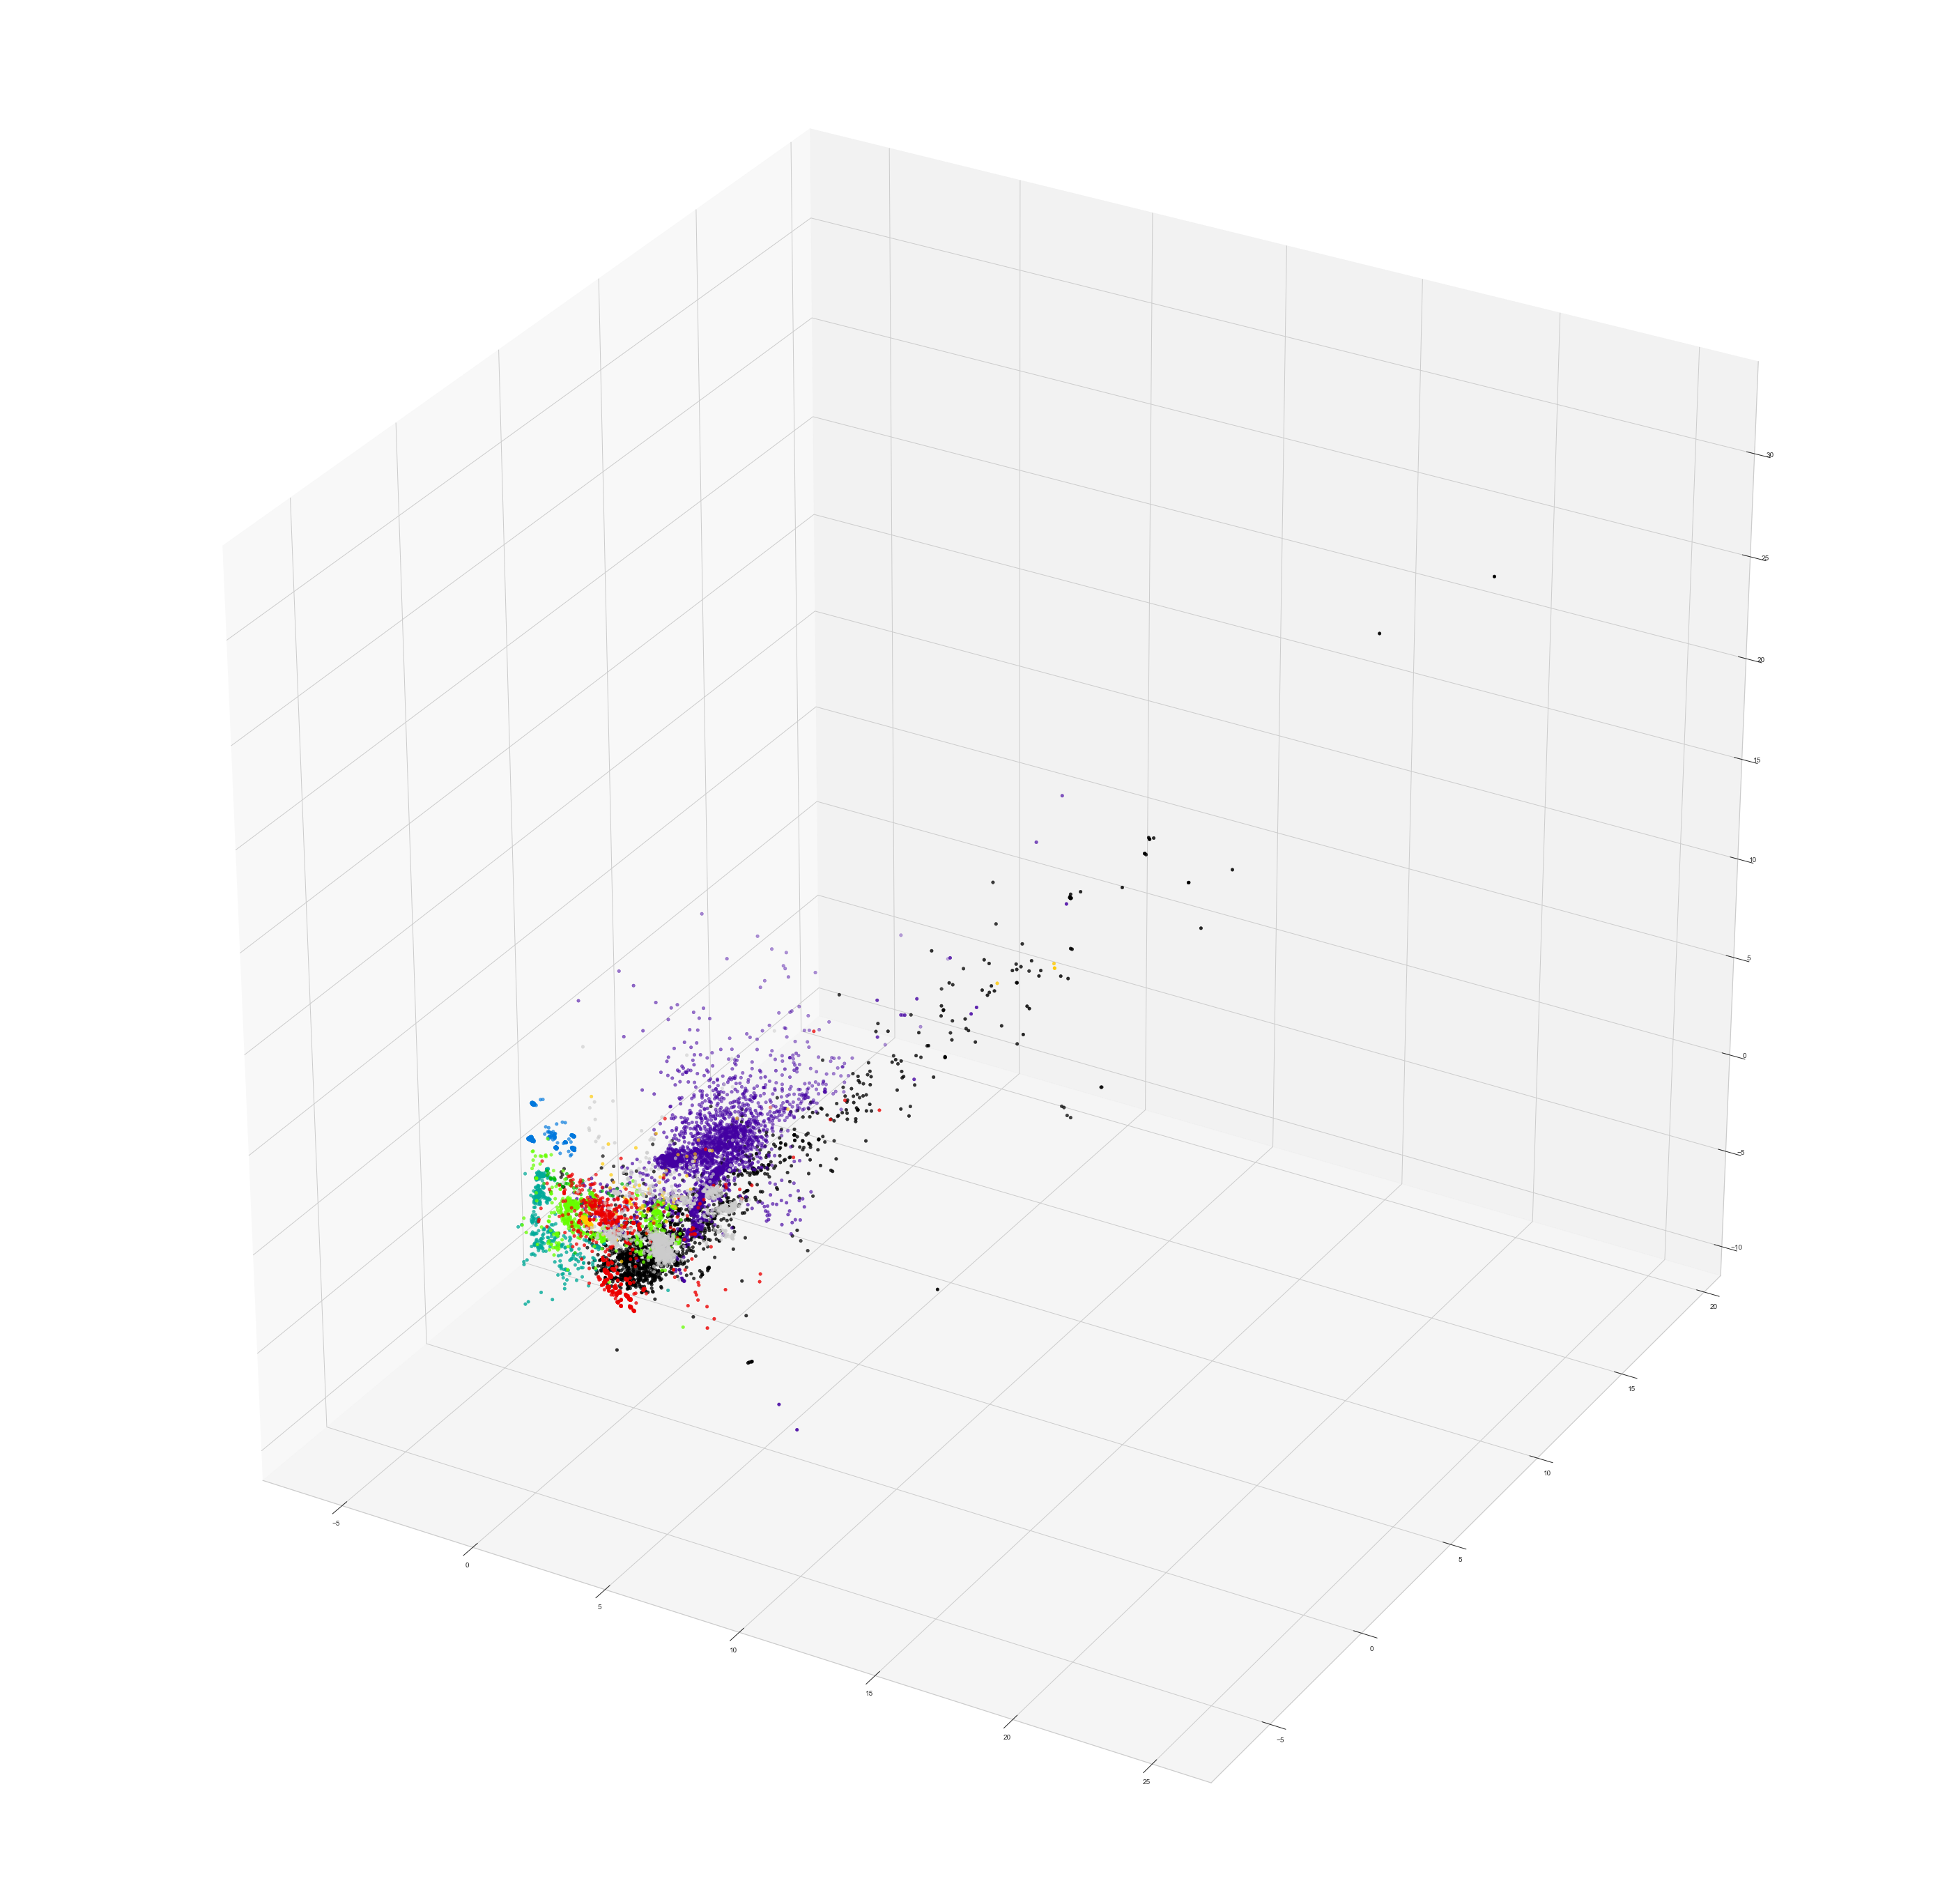

In [25]:
# draw classification of train and test in 3d 
# pca
pca_plot(data, labels)

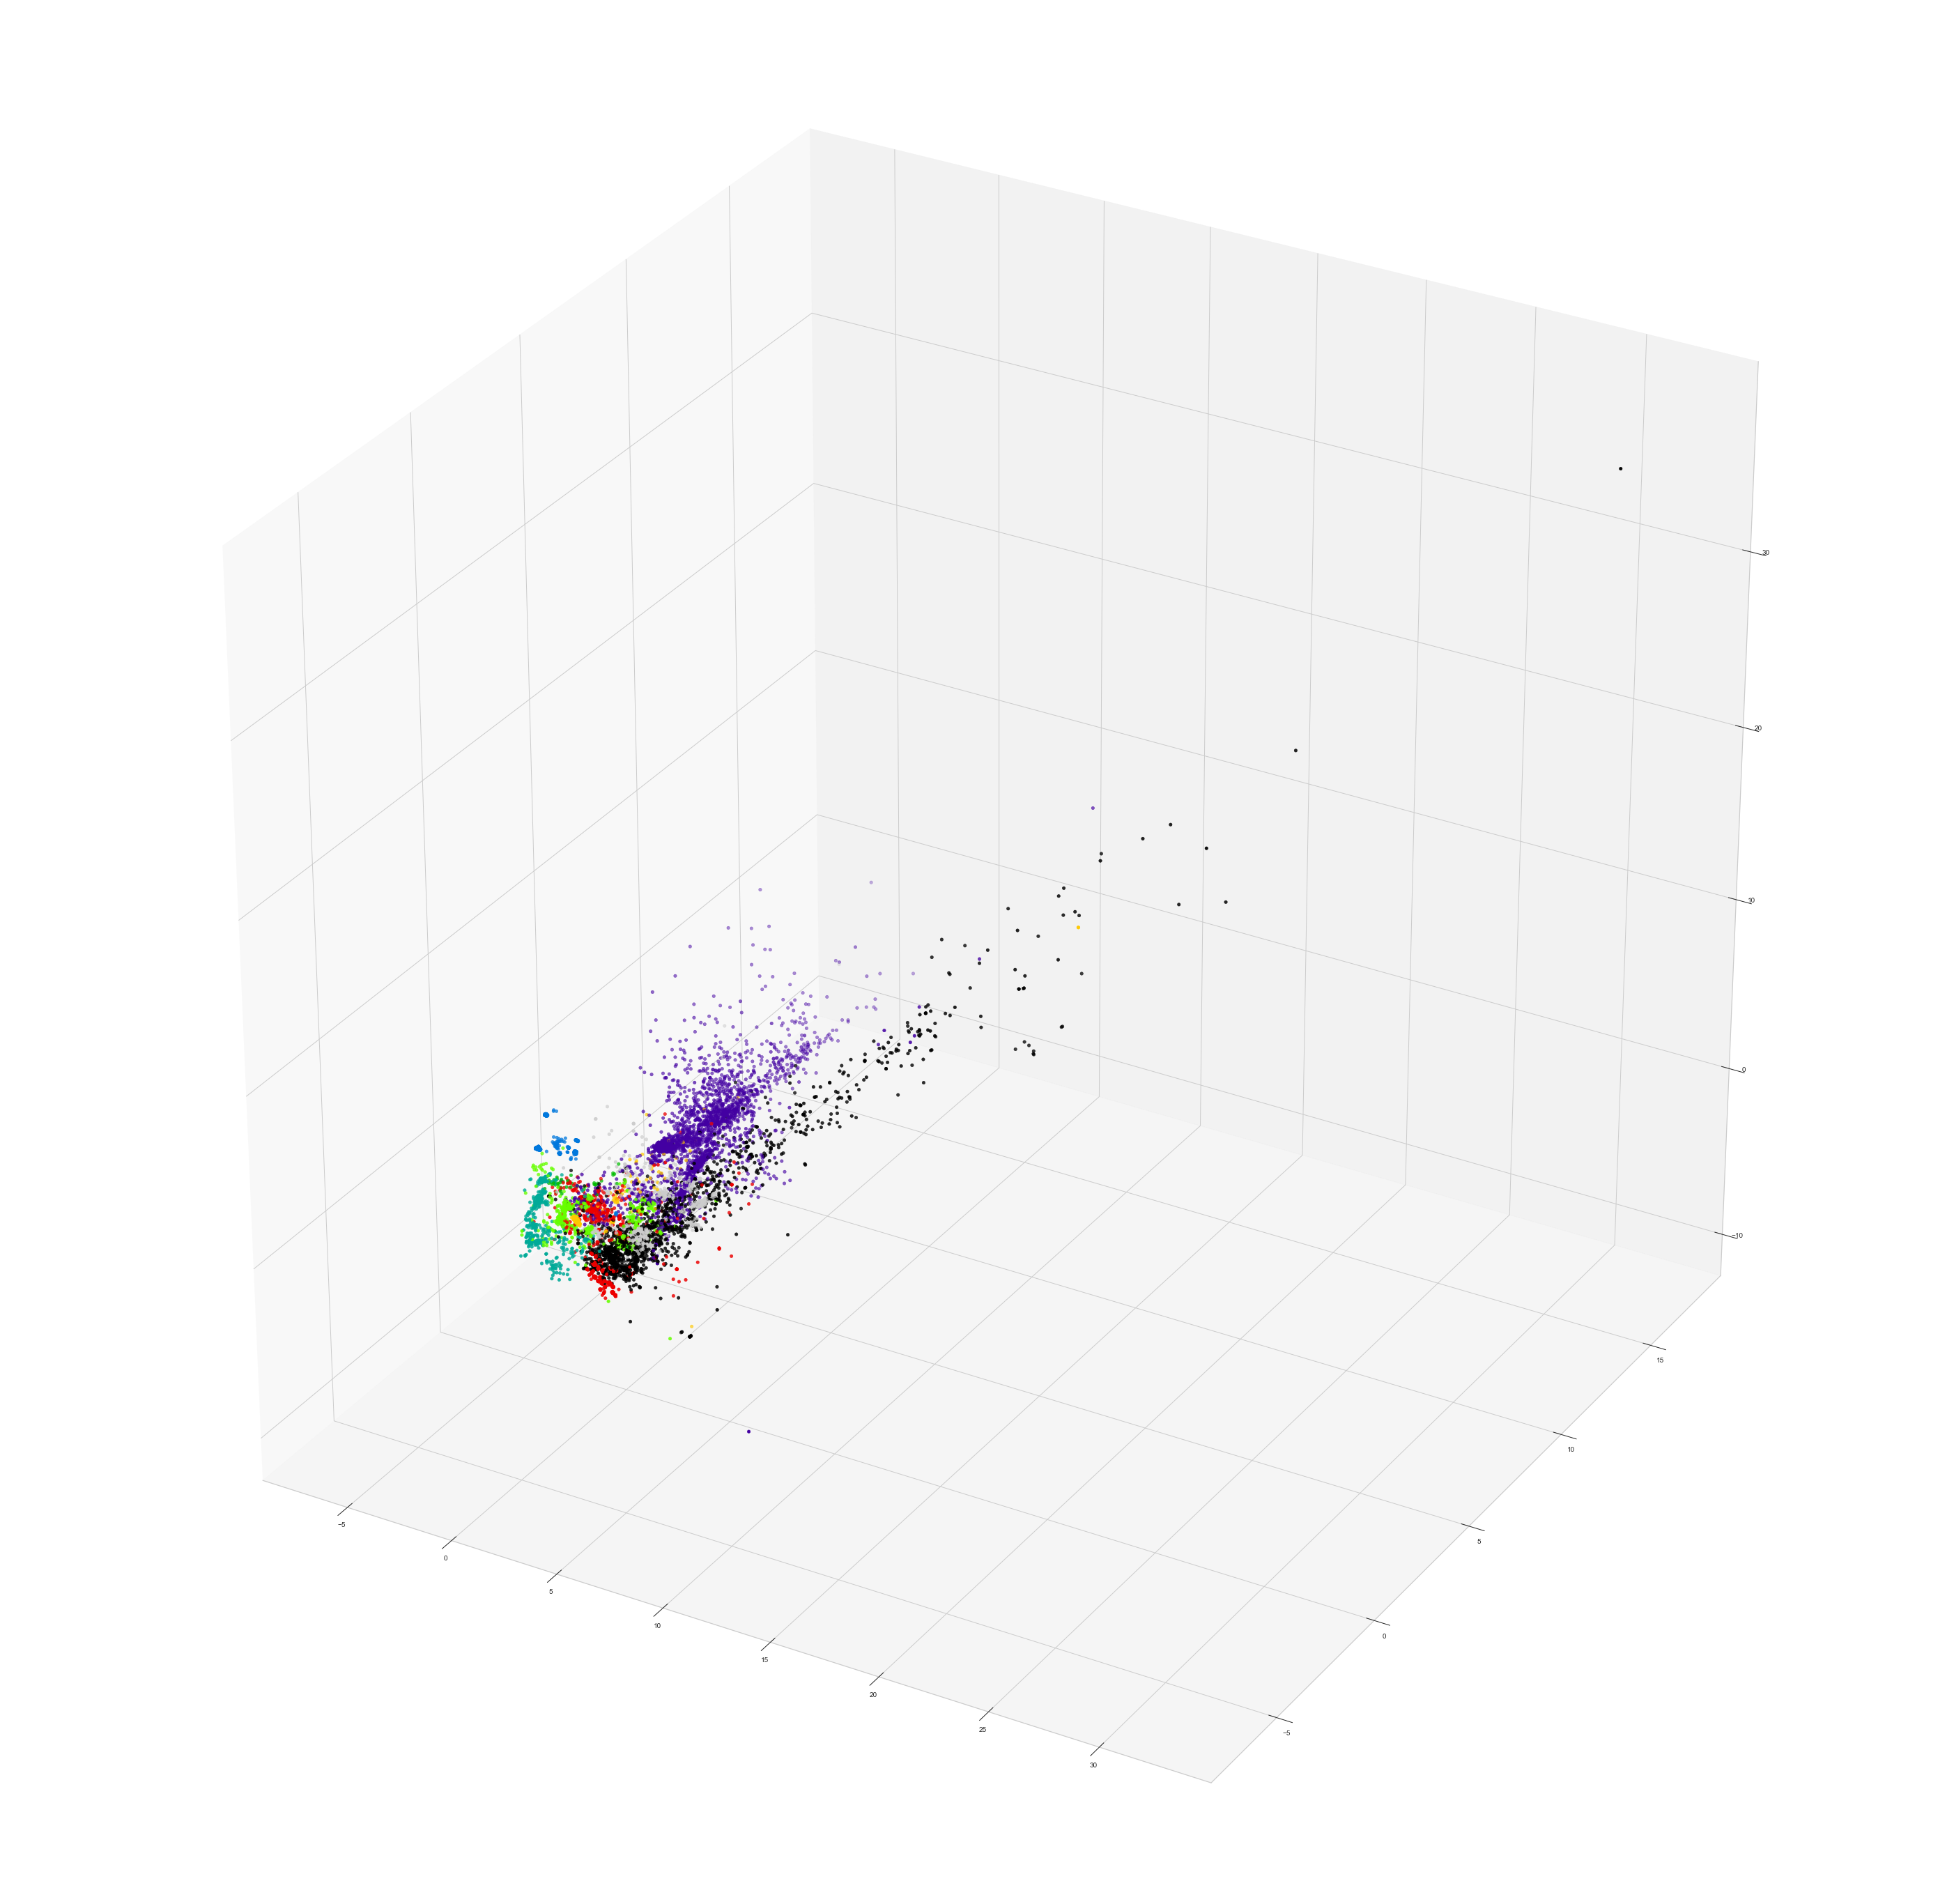

In [26]:
pca_plot(data_test, predicted_classes_on_kaggle_testset)

<br><br><br>


***


# Submission

Sada ćemo kreirati datoteku s kojom ćemo provjeriti ( _logloss_ ) točnost _test_ skupa na [Kaggle-u](https://www.kaggle.com/c/malware-classification/overview).

In [ ]:
# define model to use for submission
# model = best_model

In [27]:
# make a submisson file
submission = make_submisson_file(md5hash_test, model.predict_proba(selected_features_test[ list(feature_importances["feature_name"].values[:number_of_features_to_use]) ]))

Ime za submisson file? prvo_bustanje


In [28]:
submission.head()

,Id,Prediction1,Prediction2,Prediction3,Prediction4,Prediction5,Prediction6,Prediction7,Prediction8,Prediction9
0,ITSUPtCmh7WdJcsYDwQ5,0.000011,0.000008,0.000022,0.000019,0.999834,0.000033,0.000042,0.000018,0.000014
1,Ig2DB5tSiEy1cJvV0zdw,0.000002,0.000004,0.000011,0.000009,0.999927,0.000006,0.000031,0.000004,0.000007
2,Jmo6eIhLZ4t9r8QsxEg5,0.000003,0.000015,0.000018,0.000016,0.999883,0.000022,0.000018,0.000011,0.000015
3,JtPFl4ewgdD78OzCMa3o,0.000055,0.000054,0.000087,0.000132,0.998089,0.001389,0.000067,0.000075,0.000053
4,K3ZtByPHGSFYNljDUEXp,0.000002,0.000007,0.999934,0.000008,0.000016,0.000006,0.000015,0.000004,0.000008




<br><br><br><br>

***


<center><i>Stanišić Matea, Škrabo Petra, Terzanović Mateja, Tolja Margarita</i> </center>